# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização dos Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0.1, 1)
    return np.where(x < 0, 0.1*x, x)

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def ones(layers_size):
    weights = [np.ones((out, inp)) for inp, out in zip(layers_size[:-1], layers_size[1:])]
    biases = [np.ones((1, out)) for out in layers_size[1:]]
    return weights, biases

def random_uniform(layers_size):
    weights = [np.random.rand(out, inp) for inp, out in zip(layers_size[:-1], layers_size[1:])]
    biases = [np.random.rand(1, out) for out in layers_size[1:]]
    return weights, biases

def random_normal(layers_size):
    weights = [np.random.randn(out, inp) for inp, out in zip(layers_size[:-1], layers_size[1:])]
    biases = [np.random.randn(1, out) for out in layers_size[1:]]
    return weights, biases

def glorot_uniform(layers_size):
    # uniforme de [-limit, limit], onde limit = np.sqrt(6.0 / (out + inp))
    w_limit = [np.sqrt(6.0 / (out + inp)) for inp, out in zip(layers_size[:-1], layers_size[1:])]
    b_limit = [np.sqrt(6.0 / out) for out in layers_size[1:]]
    weights = [2*limit*np.random.rand(out, inp) - limit for inp, out, limit in zip(layers_size[:-1], layers_size[1:], w_limit)]
    biases = [2*limit*np.random.rand(1, out) - limit for out, limit in zip(layers_size[1:], b_limit)]
    return weights, biases

def glorot_normal(layers_size): 
    # normal com media=0 e stddev=sqrt(3.0 / (out + inp)). Ver notas de np.random.randn.
    w_stddev = [np.sqrt(3.0 / (out + inp)) for inp, out in zip(layers_size[:-1], layers_size[1:])]
    b_stddev = [np.sqrt(3.0 / out) for out in layers_size[1:]]
    weights = [std*np.random.randn(out, inp) for inp, out, std in zip(layers_size[:-1], layers_size[1:], w_stddev)]
    biases = [std*np.random.randn(1, out) for out, std in zip(layers_size[1:], b_stddev)]
    return weights, biases

# Regularização

###### Dos Pesos

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return [np.where(w > 0, 1, w) for w in weights]
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return np.sum([0.5*np.sum(w**2) for w in weights])

# Implementação 

In [27]:
class NeuralNetwork():
    def __init__(self, layers_size, activations, cost_func, learning_rate=1e-3, initializer=random_normal, reg_func=l2_regularization, reg_strength=0.0):
        self.layers_size = layers_size
        self.activations = activations
        self.cost_func = cost_func
        self.reg_func = reg_func
        self.learning_rate = learning_rate
        self.reg_strength = reg_strength
        self._activ_inp = []
        self._activ_out = []
        self.weights, self.biases = initializer(self.layers_size)
            
    def fit(self, x, y, epochs=100, verbose=10):
        for epoch in range(epochs+1):
            y_pred = self.__feedforward(x)
            self.__backprop(y, y_pred)
            
            if epoch % verbose == 0:
                cost = self.cost_func(y, y_pred) + self.reg_strength*self.reg_func(self.weights)/x.shape[0]
                print("epoch: {0:=4}/{1} cost: {2:.8f}".format(epoch, epochs, cost))
    
    def predict(self, x):
        return self.__feedforward(x)
    
    def __feedforward(self, x):
        self._activ_inp, self._activ_out = [], []
        self._activ_out.append(x)
        for w, b, activation in zip(self.weights, self.biases, self.activations):
            y = np.dot(self._activ_out[-1], w.T) + b
            self._activ_inp.append(y)
            self._activ_out.append(activation(y))
        return self._activ_out[-1]
    
    def __backprop(self, y, y_pred):
        self._activ_out.pop()
        
        last_delta = self.cost_func(y, y_pred, derivative=True)
        dweights, dbiases = [], []
        for inp, out, w, activation in zip(self._activ_inp[::-1], self._activ_out[::-1], self.weights[::-1], self.activations[::-1]):
            dactivation = activation(inp, derivative=True)*last_delta
            last_delta = np.dot(dactivation, w)
            dweights.append(np.dot(dactivation.T, out))
            dbiases.append(1.0*dactivation.sum(axis=0, keepdims=True))
            
        dreg = self.reg_func(self.weights, derivative=True)
        dweights = [dw + self.reg_strength*reg/y.shape[0] for dw, reg in zip(dweights, reversed(dreg))]
        self.weights = [w - self.learning_rate*dw for w, dw in zip(self.weights, reversed(dweights))]
        self.biases  = [b - self.learning_rate*db for b, db in zip(self.biases, reversed(dbiases))]

# Testes da Implementação

## Exemplos do Notebook da Intuição

### Exemplo 1

In [10]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 2], activations=[sigmoid, sigmoid], cost_func=mse, learning_rate=0.5)

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]])
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

nn.weights = [w1, w2]
nn.biases = [b1, b2]

nn.fit(x, y, epochs=0, verbose=1)

for w in nn.weights:
    print(w)

epoch:    0/0 cost: 0.29837111
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


### Exemplo 2

In [11]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])

D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 3, 3], activations=[relu, sigmoid, linear], cost_func=softmax_neg_log_likelihood, learning_rate=0.01)

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

nn.weights = [w1, w2, w3]
nn.biases = [b1, b2, b3]

nn.fit(x, y, epochs=300, verbose=30)

for w in nn.weights:
    print(w)

epoch:    0/300 cost: 1.16744561
epoch:   30/300 cost: 0.60797958
epoch:   60/300 cost: 0.36558760
epoch:   90/300 cost: 0.24943452
epoch:  120/300 cost: 0.18547915
epoch:  150/300 cost: 0.14614615
epoch:  180/300 cost: 0.11990516
epoch:  210/300 cost: 0.10131084
epoch:  240/300 cost: 0.08751844
epoch:  270/300 cost: 0.07691721
epoch:  300/300 cost: 0.06853445
[[ 0.10083595  0.2016719   0.30585165]
 [ 0.30086971  0.20173942  0.70608796]
 [ 0.40145052  0.30290104  0.91015363]]
[[ 0.20544723  0.30673159  0.50749567]
 [ 0.30994562  0.5123005   0.71366784]
 [ 0.61065514  0.41317913  0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [11]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [12]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 1.0


epoch:    0/1000 cost: 5752.10702083
epoch:  100/1000 cost: 31.83162570
epoch:  200/1000 cost: 26.24711867
epoch:  300/1000 cost: 26.11941263
epoch:  400/1000 cost: 26.11656691
epoch:  500/1000 cost: 26.11651486
epoch:  600/1000 cost: 26.11651569
epoch:  700/1000 cost: 26.11651601
epoch:  800/1000 cost: 26.11651607
epoch:  900/1000 cost: 26.11651608
epoch: 1000/1000 cost: 26.11651608
[array([[ 33.60159396]])]
[array([[ 74.99636175]])]


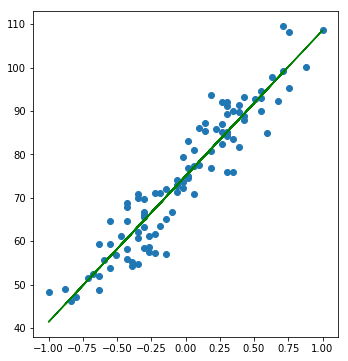

In [13]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 1], activations=[linear], cost_func=mse, learning_rate=1e-3, reg_func=l1_regularization, reg_strength=0.1)
nn.fit(x, y, epochs=1000, verbose=100)

print(nn.weights)
print(nn.biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [15]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [16]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [ 1.  1.  1.]


In [18]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 1], activations=[linear], cost_func=mse, learning_rate=1e-2, reg_func=l1_regularization, reg_strength=0.1)
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.weights)
print(nn.biases)

epoch:    0/2000 cost: 26078.53985268
epoch:  200/2000 cost: 11.96798224
epoch:  400/2000 cost: 10.75713631
epoch:  600/2000 cost: 10.65757302
epoch:  800/2000 cost: 10.64657714
epoch: 1000/2000 cost: 10.64540643
epoch: 1200/2000 cost: 10.64533872
epoch: 1400/2000 cost: 10.64536044
epoch: 1600/2000 cost: 10.64537432
epoch: 1800/2000 cost: 10.64538012
epoch: 2000/2000 cost: 10.64538232
[array([[  8.71767153,  14.09286592,  26.26447537]])]
[array([[ 150.65678855]])]


### Regressão Quadrática

In [19]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [20]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 2184.22471760
epoch: 1000/10000 cost: 97.71183715
epoch: 2000/10000 cost: 49.39591463
epoch: 3000/10000 cost: 40.92058567
epoch: 4000/10000 cost: 38.30231890
epoch: 5000/10000 cost: 37.27321061
epoch: 6000/10000 cost: 36.80021126
epoch: 7000/10000 cost: 36.55400797
epoch: 8000/10000 cost: 36.41077018
epoch: 9000/10000 cost: 36.32175706
epoch: 10000/10000 cost: 36.26415834


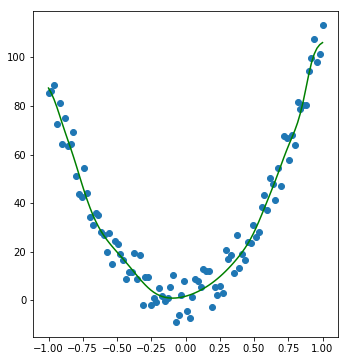

In [22]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[tanh, tanh, linear], cost_func=mse, learning_rate=1e-5, reg_func=l2_regularization, reg_strength=1e-2)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [23]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [24]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 139.58438736
epoch: 1000/10000 cost: 65.32125801
epoch: 2000/10000 cost: 40.05167371
epoch: 3000/10000 cost: 26.58720103
epoch: 4000/10000 cost: 22.40949701
epoch: 5000/10000 cost: 20.73769093
epoch: 6000/10000 cost: 19.98003077
epoch: 7000/10000 cost: 19.59688912
epoch: 8000/10000 cost: 19.38951678
epoch: 9000/10000 cost: 19.26334022
epoch: 10000/10000 cost: 19.17989587


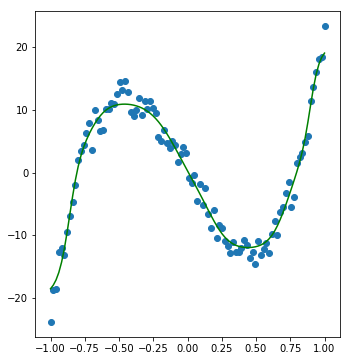

In [25]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[tanh, tanh, linear], cost_func=mse, learning_rate=1e-5, reg_func=l1_regularization, reg_strength=0.1)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [26]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [27]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 10.58022601
epoch: 1000/10000 cost: 9.00297971
epoch: 2000/10000 cost: 8.90584570
epoch: 3000/10000 cost: 8.80682593
epoch: 4000/10000 cost: 8.70658331
epoch: 5000/10000 cost: 8.60564811
epoch: 6000/10000 cost: 8.50557560
epoch: 7000/10000 cost: 8.40666193
epoch: 8000/10000 cost: 8.30741310
epoch: 9000/10000 cost: 8.20877063
epoch: 10000/10000 cost: 8.10992828


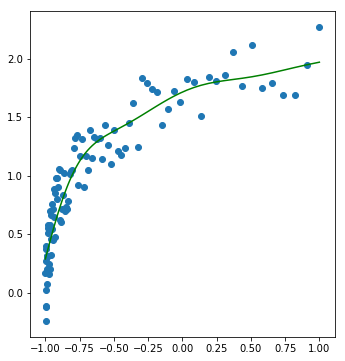

In [29]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[tanh, tanh, linear], cost_func=mse, learning_rate=1e-4, reg_func=l1_regularization, reg_strength=0.1)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [30]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [31]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/10000 cost: 2632.07259676
epoch: 1000/10000 cost: 38.43357504
epoch: 2000/10000 cost: 36.74100437
epoch: 3000/10000 cost: 36.70697849
epoch: 4000/10000 cost: 36.67568817
epoch: 5000/10000 cost: 36.64334128
epoch: 6000/10000 cost: 36.61206060
epoch: 7000/10000 cost: 36.58240534
epoch: 8000/10000 cost: 36.52598479
epoch: 9000/10000 cost: 36.49488481
epoch: 10000/10000 cost: 36.46569362


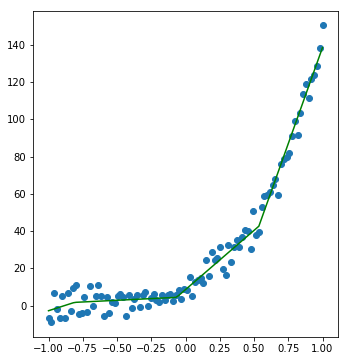

In [33]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 10, 10, 1], activations=[relu, relu, linear], cost_func=mse, learning_rate=1e-5, reg_func=l1_regularization, reg_strength=0.1)
nn.fit(x, y, epochs=10000, verbose=1000)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [28]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 1.19053292
epoch: 1000/5000 cost: 0.40351694
epoch: 2000/5000 cost: 0.40351694
epoch: 3000/5000 cost: 0.40351694
epoch: 4000/5000 cost: 0.40351694
epoch: 5000/5000 cost: 0.40351694
[array([[ 1.20737699,  1.20737699]])] [array([[-2.22483478]])]
[[ 0.09754238]
 [ 0.26552289]
 [ 0.26552289]
 [ 0.5473376 ]]


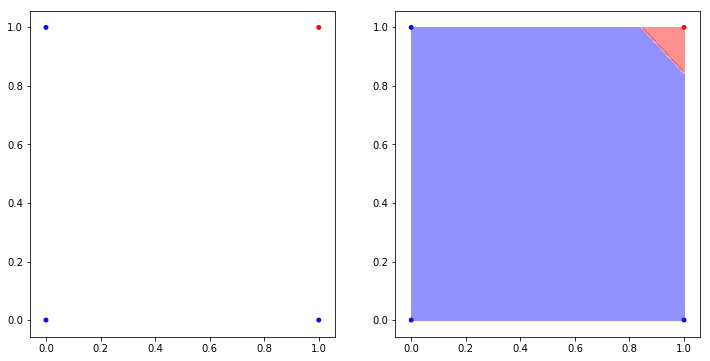

In [31]:
D = x.shape[1]

nn = NeuralNetwork(layers_size=[D, 1], activations=[sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0, reg_func=l2_regularization, reg_strength=0.2)
nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.weights, nn.biases)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [38]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 cost: 1.07673356
epoch: 1000/5000 cost: 0.69228906
epoch: 2000/5000 cost: 0.34939244
epoch: 3000/5000 cost: 0.34904538
epoch: 4000/5000 cost: 0.34904464
epoch: 5000/5000 cost: 0.34904464
[[ 0.17589443]
 [ 0.82410557]
 [ 0.82410557]
 [ 0.17589443]]


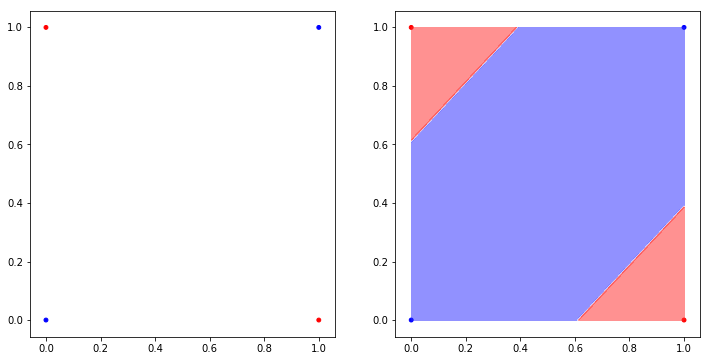

In [44]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 1], activations=[sigmoid, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1.0, reg_func=l2_regularization, reg_strength=0.003)

nn.fit(x, y, epochs=5000, verbose=1000)
print(nn.predict(x))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

In [45]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 cost: 1.15268822
epoch: 1000/5000 cost: 0.29399728
epoch: 2000/5000 cost: 0.31050646
epoch: 3000/5000 cost: 0.31417528
epoch: 4000/5000 cost: 0.31497904
epoch: 5000/5000 cost: 0.31512024


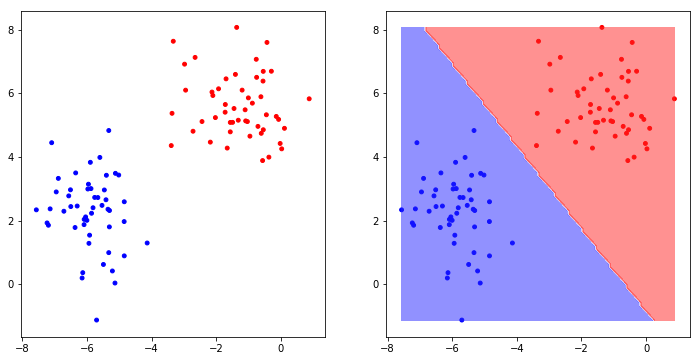

In [46]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 1], activations=[sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3, reg_func=l2_regularization, reg_strength=0.3)

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

In [47]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/5000 cost: 3.24262870
epoch: 1000/5000 cost: 1.45390731
epoch: 2000/5000 cost: 1.45997003
epoch: 3000/5000 cost: 1.45827198
epoch: 4000/5000 cost: 1.45114552
epoch: 5000/5000 cost: 1.44079230


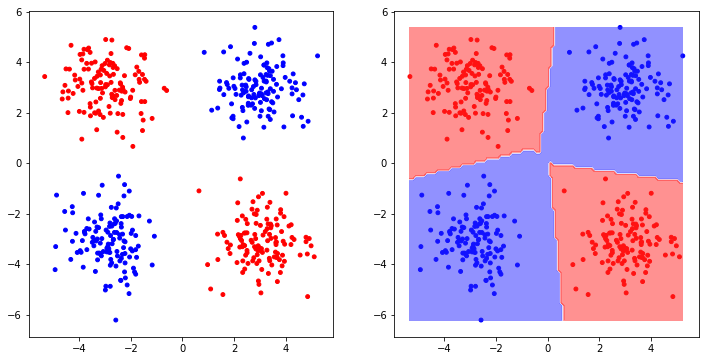

In [50]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 4, 4, 1], activations=[relu, relu, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-4, reg_func=l2_regularization, reg_strength=0.1)

nn.fit(x, y, epochs=5000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [51]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/10000 cost: 6.68813865
epoch: 1000/10000 cost: 7.91849926
epoch: 2000/10000 cost: 7.07342690
epoch: 3000/10000 cost: 6.46413842
epoch: 4000/10000 cost: 6.05247274
epoch: 5000/10000 cost: 5.78406084
epoch: 6000/10000 cost: 5.63388943
epoch: 7000/10000 cost: 5.54465871
epoch: 8000/10000 cost: 5.48959058
epoch: 9000/10000 cost: 5.45467753
epoch: 10000/10000 cost: 5.43004957


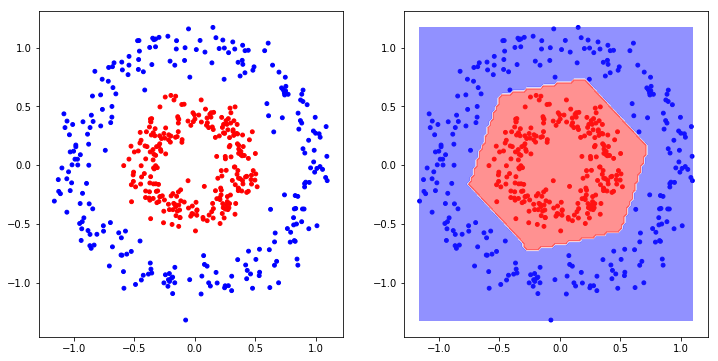

In [56]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 5, 5, 1], activations=[relu, relu, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3, reg_func=l2_regularization, reg_strength=0.3)
nn.fit(x, y, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [57]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 cost: 0.49656061
epoch: 2000/20000 cost: 0.32428368
epoch: 4000/20000 cost: 0.32136963
epoch: 6000/20000 cost: 0.31892268
epoch: 8000/20000 cost: 0.31642793
epoch: 10000/20000 cost: 0.31327473
epoch: 12000/20000 cost: 0.30911474
epoch: 14000/20000 cost: 0.30516583
epoch: 16000/20000 cost: 0.27892947
epoch: 18000/20000 cost: 0.24051982
epoch: 20000/20000 cost: 0.21761599


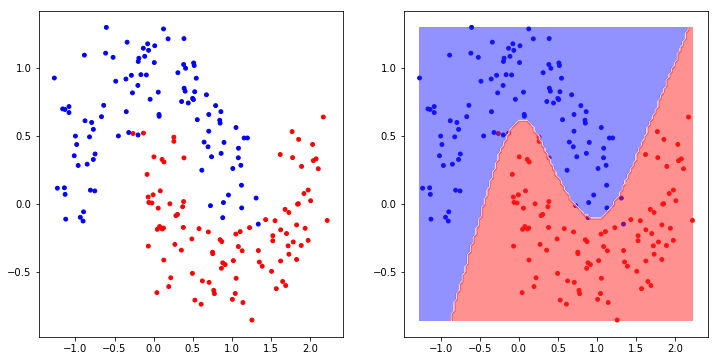

In [64]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 1], activations=[tanh, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3, reg_func=l2_regularization, reg_strength=0.003)

nn.fit(x, y, epochs=20000, verbose=2000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [65]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/20000 cost: 1.53560268
epoch: 2000/20000 cost: 0.48974292
epoch: 4000/20000 cost: 0.40344701
epoch: 6000/20000 cost: 0.36580683
epoch: 8000/20000 cost: 0.33868580
epoch: 10000/20000 cost: 0.31949988
epoch: 12000/20000 cost: 0.30070434
epoch: 14000/20000 cost: 0.28498411
epoch: 16000/20000 cost: 0.27284390
epoch: 18000/20000 cost: 0.26234616
epoch: 20000/20000 cost: 0.24453484


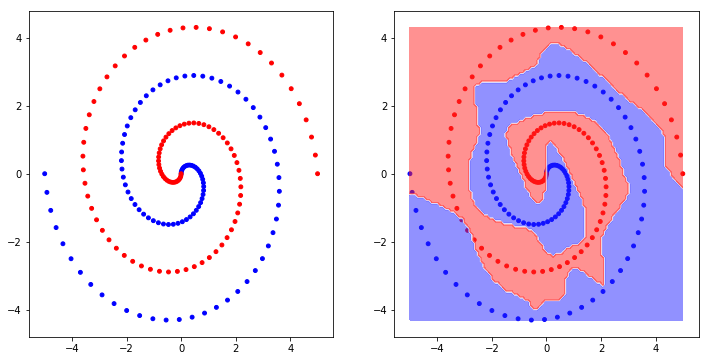

In [74]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 8, 8, 1], activations=[tanh, tanh, sigmoid], cost_func=sigmoid_cross_entropy, learning_rate=1e-3, reg_func=l1_regularization, reg_strength=0.001)
nn.fit(x, y, epochs=20000, verbose=2000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [75]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [76]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


epoch:    0/10000 cost: 8.58084797
epoch: 1000/10000 cost: 0.74016200
epoch: 2000/10000 cost: 0.72593513
epoch: 3000/10000 cost: 0.72056359
epoch: 4000/10000 cost: 0.71765211
epoch: 5000/10000 cost: 0.71596011
epoch: 6000/10000 cost: 0.71463250
epoch: 7000/10000 cost: 0.71360288
epoch: 8000/10000 cost: 0.71283225
epoch: 9000/10000 cost: 0.71222338
epoch: 10000/10000 cost: 0.71177843


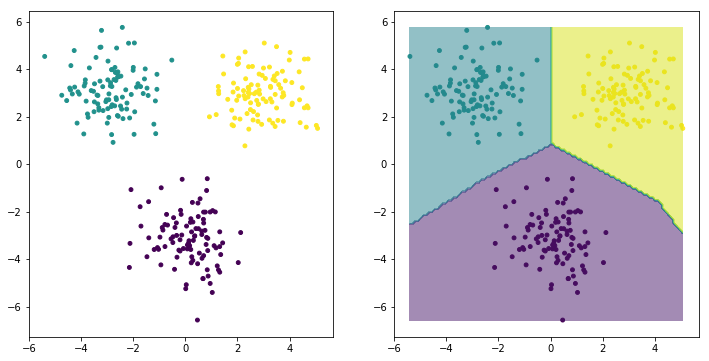

In [77]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 3], activations=[relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, reg_func=l2_regularization, reg_strength=0.5)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [78]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [79]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


epoch:    0/10000 cost: 2.30772965
epoch: 1000/10000 cost: 0.58812412
epoch: 2000/10000 cost: 0.49716742
epoch: 3000/10000 cost: 0.46348323
epoch: 4000/10000 cost: 0.44414015
epoch: 5000/10000 cost: 0.43090100
epoch: 6000/10000 cost: 0.42145504
epoch: 7000/10000 cost: 0.41426425
epoch: 8000/10000 cost: 0.40848297
epoch: 9000/10000 cost: 0.40366346
epoch: 10000/10000 cost: 0.39929705


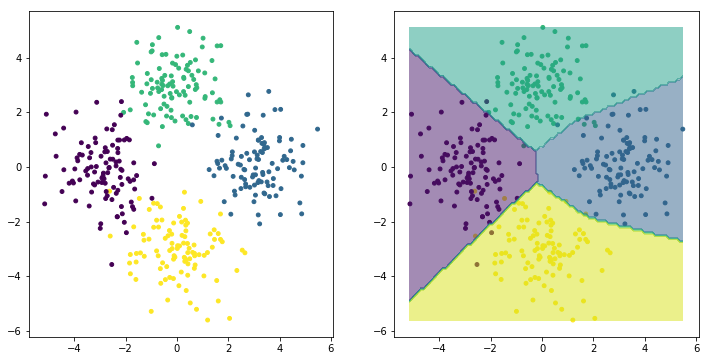

In [81]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 3, 4], activations=[relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, reg_func=l2_regularization, reg_strength=0.05)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [82]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [83]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


epoch:    0/10000 cost: 9.40893626
epoch: 1000/10000 cost: 0.72322540
epoch: 2000/10000 cost: 0.58622990
epoch: 3000/10000 cost: 0.54736831
epoch: 4000/10000 cost: 0.52981485
epoch: 5000/10000 cost: 0.52134076
epoch: 6000/10000 cost: 0.51665276
epoch: 7000/10000 cost: 0.51391494
epoch: 8000/10000 cost: 0.51219638
epoch: 9000/10000 cost: 0.51084835
epoch: 10000/10000 cost: 0.50972890


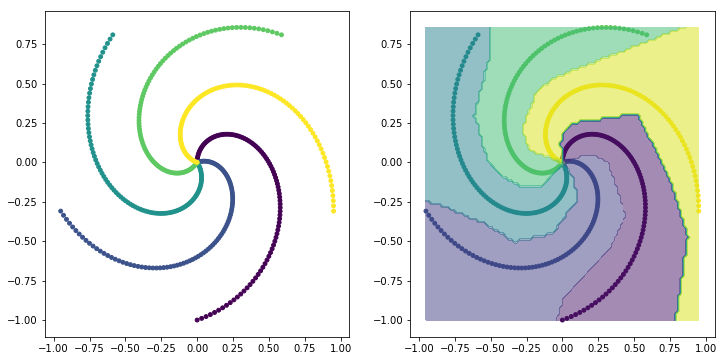

In [86]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 10, 10, 5], activations=[relu, relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, reg_func=l2_regularization, reg_strength=0.005)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [87]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [88]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


epoch:    0/10000 cost: 3.41113102
epoch: 1000/10000 cost: 1.14954503
epoch: 2000/10000 cost: 1.02136272
epoch: 3000/10000 cost: 1.00090823
epoch: 4000/10000 cost: 0.99094222
epoch: 5000/10000 cost: 0.98620471
epoch: 6000/10000 cost: 0.98333488
epoch: 7000/10000 cost: 0.98038933
epoch: 8000/10000 cost: 0.97843213
epoch: 9000/10000 cost: 0.97650730
epoch: 10000/10000 cost: 0.97538141


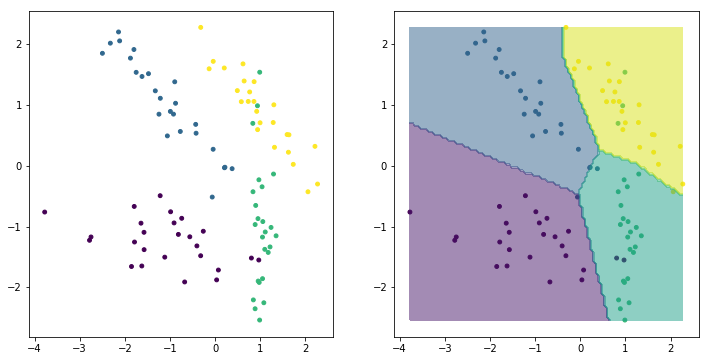

In [90]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 5, 4], activations=[relu, relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, reg_func=l2_regularization, reg_strength=0.1)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [91]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [92]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


epoch:    0/10000 cost: 2.61497325
epoch: 1000/10000 cost: 0.86703836
epoch: 2000/10000 cost: 0.71681495
epoch: 3000/10000 cost: 0.65797420
epoch: 4000/10000 cost: 0.59568660
epoch: 5000/10000 cost: 0.55046134
epoch: 6000/10000 cost: 0.52162183
epoch: 7000/10000 cost: 0.50030898
epoch: 8000/10000 cost: 0.48338221
epoch: 9000/10000 cost: 0.46933515
epoch: 10000/10000 cost: 0.45763126


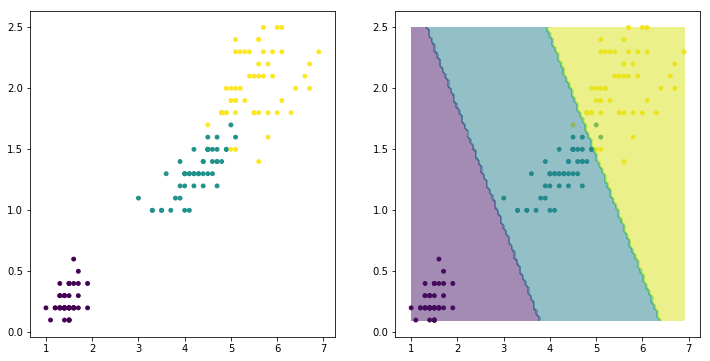

In [95]:
D = x.shape[1]
nn = NeuralNetwork(layers_size=[D, 2, 3], activations=[relu, linear], cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, reg_func=l2_regularization, reg_strength=0.05)

nn.fit(x, y_onehot, epochs=10000, verbose=1000)

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__TODO__:
- evitar overflow das funções de ativação
- mini-batch SGD
- dropout
- early_stopping

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.